### Imports

In [1]:
# For Docker image tensorflow/tensorflow:2.14.0-gpu-juptyer and latest-gpu-jupyter 
# About the latest tag: sha256:efc25f8ad0ec337e8f4e2de9e7e8e391e6729481c7a7cae4bdea3137da7822c6
!pip install -q emoji
!pip install -q nltk
!pip install -q scikit-learn
!pip install -q transformers
!pip install -q tf-keras

In [2]:
from typing import Union
from emoji import demojize, is_emoji
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
import numpy as np
from numpy import ndarray
from sklearn.metrics import f1_score, recall_score
import tensorflow as tf
from transformers import (
    BertConfig,
    BertTokenizer,
    TFBertForSequenceClassification,
)

2024-05-01 16:35:57.766642: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# The device_name will be used in model.fit()
gpu_devices = tf.config.experimental.list_physical_devices("GPU")

if gpu_devices:
    print("GPU available, using GPU")
    tf.config.experimental.set_visible_devices(gpu_devices[0], "GPU")
    device_name = "/GPU:0"
else:
    print("GPU not available, using CPU")
    device_name = "/CPU:0"

GPU available, using GPU


2024-05-01 16:35:59.255093: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 16:35:59.259362: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 16:35:59.259399: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


### Function for loading data set

In [4]:
def load_text_file(file_path: str) -> list[str]:
    """
    Load a text file and return an array of lines from the file.

    Args:
        file_path: str: The path to the file to load.

    Returns:
        list[str]: An array of lines from the file.
    """
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

### Load the text files

In [5]:
train_text_path: str = "../dataset/train_text.txt"
train_label_path: str = "../dataset/train_labels.txt"

test_text_path: str = "../dataset/test_text.txt"
test_label_path: str = "../dataset/test_labels.txt"

validationt_text_path: str = "../dataset/val_text.txt"
validationt_label_path: str = "../dataset/val_labels.txt"

train_text: list[str] = load_text_file(train_text_path)
train_label: list[str] = load_text_file(train_label_path)

test_text: list[str] = load_text_file(test_text_path)
test_label: list[str] = load_text_file(test_label_path)

validation_text: list[str] = load_text_file(validationt_text_path)
validation_label: list[str] = load_text_file(validationt_label_path)

### Preprocessing

#### Declere global variables

In [6]:
tokenizer = TweetTokenizer()

### Functions for preprocessing

In [7]:
def text_processing(text: list[str]) -> list[str]:
    """
    Process text data:
    - Remove "@user"
    - Remove "#".
    - Replace "’" and triple dots in one character (…).
    - Tokenize and lowercase.
    - Normalize the tokens and join the line.
    - Replace specific strings.
    - Remove excess space after processing.

    Args:
        text: list[str]: A list of text data.

    Returns:
        list[str]: A list of processed sentences
    """
    processed_text = []
    for line in text:
        # Remove @user
        line = line.replace("@user", "")
        # Remove #
        line = line.replace("#", "")
        # Replace "’" and triple dots in one character (…)
        line = line.replace("’", "'").replace("…", "...")
        # Tokenize and lowercase
        tokens = tokenizer.tokenize(line.lower())
        # Normalize the tokens and join the line
        line = " ".join([normalize_token(token) for token in tokens])
        # Replace specific strings
        line = (
            line.replace("cannot", "can not")
            .replace("can't", "can not")
            .replace("n't ", " not ")
            # Handle cases in English, where when "n't" is replace with
            # " not ", the meaning of the word will be invalid
            .replace("wo not ", "will not ")
            .replace("sha not", "shall not")
            # "ain't" can be "am/is/are not", so it stays
            .replace("ai not ", "ain't ")
        )
        line = (
            line.replace("'m ", " am ")
            .replace("'re ", " are ")
            .replace("'ll ", " will ")
            .replace("'ve ", " have ")
            # 's can mean ownership or "is"
            .replace("'s ", " 's ")
            # 'd can mean "would" or "had"
            .replace("'d ", " 'd ")
        )
        # Remove excess spaces
        line = " ".join(line.split())
        processed_text.append(line)

    return processed_text


def normalize_token(token: str) -> str:
    """
    Normalize the provided token.
    - Replace URLs with "HTTPURL".
    - Replace emojis with respective string.

    Args:
        token: str: The string being normalized

    Return:
        str: The normalized string
    """
    if token.startswith("http") or token.startswith("www"):
        return "HTTPURL"
    elif is_emoji(token):
        return demojize(token)
    else:
        return token

### Process the text data

#### Process all text data

See function docstring from text_processing()

In [8]:
train_text: list[str] = text_processing(train_text)
test_text: list[str] = text_processing(test_text)
validation_text: list[str] = text_processing(validation_text)

##### Convert the labels to integers

In [9]:
validation_labels = [int(x) for x in validation_label]
train_labels = [int(x) for x in train_label]
test_labels = [int(x) for x in test_label]

### Transformer

##### Configurable parameters

In [10]:
number_of_epochs: int = 2
batch_size: int = 16
dropout_rate: float = 0.3
learning_rate: float = 0.00001

custom_config = BertConfig.from_pretrained("bert-base-uncased")
custom_config.hidden_dropout_prob = dropout_rate
custom_config.num_labels = 3

##### Load pre-trained BERT model and tokenizer

In [11]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-uncased", config=custom_config
)

2024-05-01 16:36:03.392232: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 16:36:03.392323: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 16:36:03.392345: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 16:36:03.482405: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 16:36:03.482449: I external/local_xla/xla/stream_executor

##### Tokenize and pad sequences

In [12]:
train_encodings = tokenizer(
    train_text, padding=True, truncation=True, return_tensors="tf"
)
validation_encodings = tokenizer(
    validation_text, padding=True, truncation=True, return_tensors="tf"
)

##### Convert labels to TensorFlow tensors

In [13]:
train_labels_tensor = tf.convert_to_tensor(tf.one_hot(train_labels, 3))
validation_labels_tensor = tf.convert_to_tensor(tf.one_hot(validation_labels, 3))

##### Define the model

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

##### Variables for logging the history

In [15]:
train_loss: list[float] = []
train_accuracy: list[float] = []
validation_loss: list[float] = []
validation_accuracy: list[float] = []

##### Train the model

Because model.fit() will crash if I put validation_data inside

I created a manual version of history = model.fit(), with validation data

In [16]:
with tf.device(device_name):
    for i in range(number_of_epochs):
        model.fit(train_encodings, train_labels_tensor, batch_size=batch_size)
        # Get the loss and accuracy after the current epoch
        loss, accuracy = model.evaluate(train_encodings, train_labels_tensor, verbose=0)
        train_loss.append(loss)
        train_accuracy.append(accuracy)
        loss, accuracy = model.evaluate(
            validation_encodings, validation_labels_tensor, verbose=0
        )
        validation_loss.append(loss)
        validation_accuracy.append(accuracy)
        print(f"Epoch {i+1} done. Validation accuracy: {accuracy}, loss: {loss}")

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1714581418.635347   13272 service.cc:145] XLA service 0x7f21de9b9b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714581418.635387   13272 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-05-01 16:36:58.640348: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-01 16:36:58.652438: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1714581418.694770   13272 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2851/2851 [==============================] - 550s 176ms/step - loss: 0.7125 - accuracy: 0.6736
Epoch 1 done. Validation accuracy: 0.7294999957084656, loss: 0.6168274283409119
2851/2851 [==============================] - 503s 177ms/step - loss: 0.6010 - accuracy: 0.7320
Epoch 2 done. Validation accuracy: 0.7145000100135803, loss: 0.6399126648902893


##### Plot the graphs

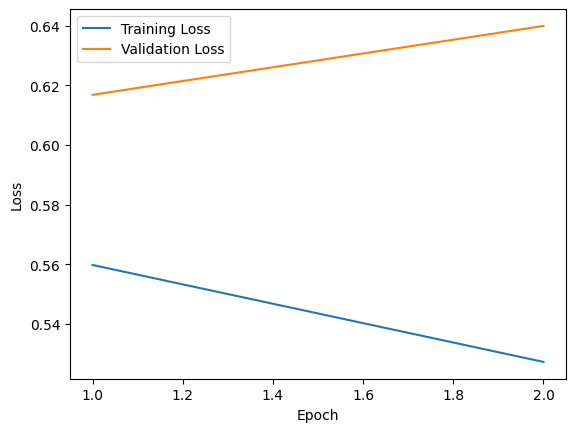

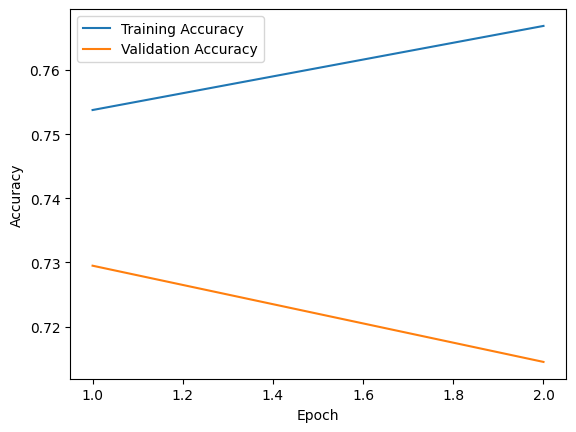

In [17]:
# Loss
epochs = range(1, number_of_epochs + 1)
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, validation_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Accuracy
plt.plot(epochs, train_accuracy, label="Training Accuracy")
plt.plot(epochs, validation_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Function for optimising

In [18]:
def modify_decision_boundary(prediction: ndarray[float], boundary: float) -> list[int]:
    """
    Adjust decision method, make the model tend to predict
    "Netural" more, according to the distribution of the dataset

    If either the score of positive or negative class is in the
    +-boundary range of the netural score, and the remaining class is
    not significant higher that the netural class ()
    It will be classified as netural

    Args:
        prediction: ndarray[float]: The prediction with socres for each entry.
        boundary: float: The boundary, should be between 0 and 1.

    Return:
        ndarray[int]: The new prediction
    """
    final_result: list[int] = []
    for row in prediction:
        # If the class with the highest score is netural
        if np.max(row) == row[1]:
            final_result.append(1)
            continue

        negative: float = row[0]
        netural: float = row[1]
        positive: float = row[2]

        # Get the netural score range
        min_netural: float = netural * (1 - boundary)
        max_netural: float = netural * (1 + boundary)

        # If score for negative is in netural range and it is the class with highest score
        if min_netural <= negative <= max_netural and np.max(row) == negative:
            final_result.append(1)
        # If score for positive is in netural range and it is the class with highest score
        elif min_netural <= positive <= max_netural and np.max(row) == positive:
            final_result.append(1)
        elif np.max(row) == negative:
            final_result.append(0)
        elif np.max(row) == positive:
            final_result.append(2)

    return final_result

##### Find the best boundary by validation data

63/63 [==============================] - 10s 80ms/step


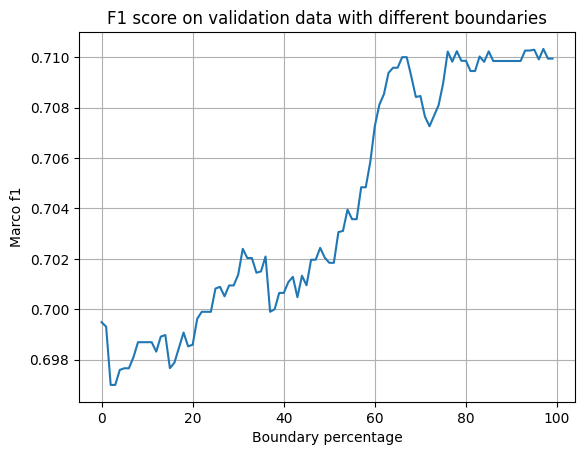

In [19]:
validation_prediction = model.predict(validation_encodings)
prediction_matrix: ndarray[float] = validation_prediction.logits

start = 0.0
boundary_f1: list[float] = []
while start < 1.0:
    fin_res = modify_decision_boundary(prediction_matrix, start)
    boundary_f1.append(f1_score(validation_labels, fin_res, average="macro"))
    start += 0.01

x_axis = list(range(100))
plt.plot(x_axis, boundary_f1)
plt.xlabel("Boundary percentage")
plt.ylabel("Marco f1")
plt.title("F1 score on validation data with different boundaries")
plt.grid(True)
plt.show()

### Final test on the trained model

##### F1 scores

In [20]:
test_encodings = tokenizer(
    test_text, padding=True, truncation=True, return_tensors="tf"
)
test_labels = tf.convert_to_tensor(tf.one_hot(test_labels, 3))

netural_range: float = boundary_f1.index(max(boundary_f1)) * 0.01
print(f"Boundary used: {netural_range}")

test_prediction = model.predict(test_encodings)
test_labels = np.argmax(test_labels, axis=1)
prediction_matrix: ndarray[float] = test_prediction.logits

final_result = modify_decision_boundary(prediction_matrix, netural_range)
f1_scores_processed = f1_score(test_labels, final_result, average=None)
macro_average_f1_processed = np.mean(f1_scores_processed)

print("F1 scores for each class:", f1_scores_processed)
print("Macro-averaged F1 score:", macro_average_f1_processed)

Boundary used: 0.97
384/384 [==============================] - 55s 130ms/step
F1 scores for each class: [0.72897663 0.69789811 0.67566048]
Macro-averaged F1 score: 0.7008450763477296


##### Recall

In [21]:
recall_per_class = recall_score(test_labels, final_result, average=None)
macro_average_recall = sum(recall_per_class) / len(recall_per_class)

print("Recall for each class:", recall_per_class)
print("Macro-averaged recall:", macro_average_recall)

Recall for each class: [0.73439074 0.65992926 0.75915789]
Macro-averaged recall: 0.7178259623611569


In [23]:
# model.save('71_recall_test.keras')

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)
